## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [2]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.layers import BatchNormalization


def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model


In [10]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [11]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping
monitor= ['val_loss','val_accuracy']



results = {}
for i in monitor:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    earlystop = EarlyStopping(monitor=i, 
                              patience=5, 
                              verbose=1)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )

    
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "monitor={}".format(i)
    results[exp_name_tag]={'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

50000/50000 [==============================] - 7s 136us/step - loss: 1.1854 - accuracy: 0.5900 - val_loss: 1.4777 - val_accuracy: 0.4822
Epoch 16/50
50000/50000 [==============================] - 7s 137us/step - loss: 1.1645 - accuracy: 0.5981 - val_loss: 1.4834 - val_accuracy: 0.4747
Epoch 17/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.1421 - accuracy: 0.6057 - val_loss: 1.4823 - val_accuracy: 0.4769
Epoch 18/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.1184 - accuracy: 0.6147 - val_loss: 1.4764 - val_accuracy: 0.4819
Epoch 19/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.0952 - accuracy: 0.6241 - val_loss: 1.4675 - val_accuracy: 0.4820
Epoch 20/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.0745 - accuracy: 0.6312 - val_loss: 1.4771 - val_accuracy: 0.4876
Epoch 21/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.0524 - accuracy: 0.6399 - val_loss:

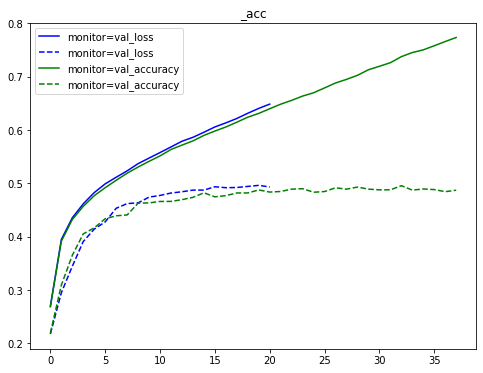

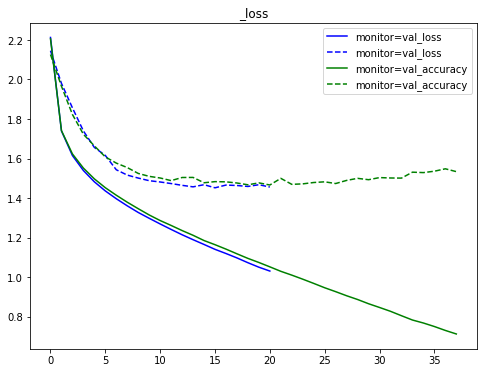

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title("_acc")
    plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.title("_loss")
    plt.legend()
plt.show()

In [13]:
from keras.callbacks import EarlyStopping
patience= [5,15,20]
results = {}
for i in patience:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    earlystop = EarlyStopping(monitor='val_loss', 
                              patience=i, 
                              verbose=1)
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )

    
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "patient={}".format(i)
    results[exp_name_tag]={'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

50000/50000 [==============================] - 9s 178us/step - loss: 1.2143 - accuracy: 0.5819 - val_loss: 1.4709 - val_accuracy: 0.4823
Epoch 14/50
50000/50000 [==============================] - 12s 240us/step - loss: 1.1882 - accuracy: 0.5912 - val_loss: 1.4789 - val_accuracy: 0.4781
Epoch 15/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.1636 - accuracy: 0.6005 - val_loss: 1.4655 - val_accuracy: 0.4818
Epoch 16/50
50000/50000 [==============================] - 8s 163us/step - loss: 1.1408 - accuracy: 0.6090 - val_loss: 1.4622 - val_accuracy: 0.4836
Epoch 17/50
50000/50000 [==============================] - 10s 207us/step - loss: 1.1162 - accuracy: 0.6187 - val_loss: 1.4631 - val_accuracy: 0.4855
Epoch 18/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.0920 - accuracy: 0.6276 - val_loss: 1.4647 - val_accuracy: 0.4857
Epoch 19/50
50000/50000 [==============================] - 8s 167us/step - loss: 1.0704 - accuracy: 0.6357 - val_los

50000/50000 [==============================] - 8s 152us/step - loss: 1.0145 - accuracy: 0.6566 - val_loss: 1.4448 - val_accuracy: 0.4991
Epoch 23/50
50000/50000 [==============================] - 7s 149us/step - loss: 0.9906 - accuracy: 0.6667 - val_loss: 1.4468 - val_accuracy: 0.4974
Epoch 24/50
50000/50000 [==============================] - 7s 148us/step - loss: 0.9709 - accuracy: 0.6748 - val_loss: 1.4511 - val_accuracy: 0.4937
Epoch 25/50
50000/50000 [==============================] - 7s 146us/step - loss: 0.9500 - accuracy: 0.6818 - val_loss: 1.4560 - val_accuracy: 0.4938
Epoch 26/50
50000/50000 [==============================] - 7s 145us/step - loss: 0.9310 - accuracy: 0.6895 - val_loss: 1.4471 - val_accuracy: 0.4973
Epoch 27/50
50000/50000 [==============================] - 7s 146us/step - loss: 0.9087 - accuracy: 0.6976 - val_loss: 1.4506 - val_accuracy: 0.5025
Epoch 28/50
50000/50000 [==============================] - 7s 146us/step - loss: 0.8893 - accuracy: 0.7060 - val_loss:

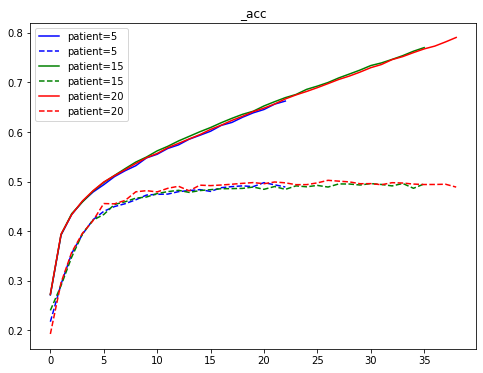

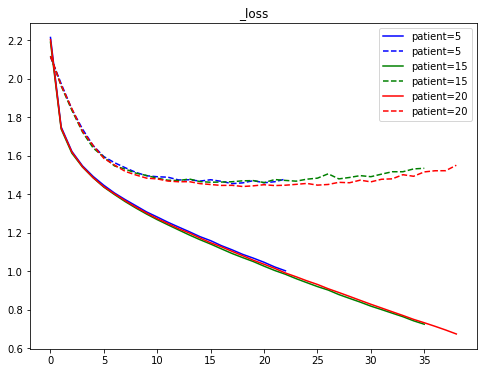

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title("_acc")
    plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.title("_loss")
    plt.legend()
plt.show()